# Maxar Image Availability Analysis

The Maxar image availability workflow takes as input a list of TerraFund project ids and returns as output a csv listing every project and how much of that project’s area has Maxar imagery coverage.

#### Workflow:
1. Pull info on project characteristics for the entire portfolio using the TerraMatch API
    - Repo/notebook: terrafund-portfolio-analysis/tm-api.ipynb
    - Input: list of TerraFund project IDs
    - Output: csv of all project features
2. Using the TM API csv, pull Maxar metadata
    - Repo/notebook: maxar-tools/decision-tree-metadata.ipynb and maxar-tools/src/decision_tree.py (? may need to change b/c of my additions to the acquire_metadata function)
    - Input: csv of project features
    - Output: csv of maxar metadata
3. Calculate the percent area of each project with available Maxar imagery
    - Repo/notebook: terrafund-portfolio-analysis/maxar-img-avail.ipynb and terrafund-portfolio-analysis/src/image_coverage.py
    - Input: csv of maxar metadata and csv of TM project features
    - Output: csv of project features and percent imagery coverage, csv of percent imagery coverage aggregated to project level, csv of polygons with low imagery coverage
4. Identify projects with highest imagery coverage to use for the RS image availability simulation

In [1]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import sys
sys.path.append('../src/')
import image_coverage as img_cover
import analyze_img_coverage as analyze
from datetime import datetime

### Parameters

In [11]:
# Naming convention
run_name = 'maxar_spenddown'
run_dir = 'maxar_spenddown'
analysis = 'most_recent' # must change if you change the date_range

# Today's date
today = datetime.today().strftime('%Y-%m-%d')
#today = '2025-04-02'

# File paths
feats = f'../data/{run_dir}/tm_api_{run_name}_{today}.csv' # CSV of polygon metadata & geometries from TM API (infile)
maxar_md = f'../data/{run_dir}/imagery_availability/comb_img_availability_{run_name}_{today}.csv' # CSV of metadata for Maxar images corresponding to polygons (infile)
dropped_poly_path = f'../data/{run_dir}/dropped_poly_invalid_geom_{run_name}_{today}.csv'
results_path = f'../data/{run_dir}/results/{analysis}/' # File path to save results to

# Define filtering thesholds (stored in a dictionary)
filters = {
    'cloud_cover': 50,          # Remove images with >50% cloud cover
    'off_nadir': 30,            # Remove images with >30° off-nadir angle
    'sun_elevation': 30,        # Keep only images where sun elevation >30°
    #'date_range': (-366, 0),    # Date range of 1 year before plantstart (TerraFund baseline)
    #'date_range': (-366, 90),    # Date range of 1 year before plantstart through 3 months after (PPC baseline)
    #'date_range': (365, 9999),    # Date range of 1 year post-plantstart through today (upper bound of maxar_md dataset is today's date) (year_2)
    #'date_range': (730, 9999),  # Date range of 2 years post-plantstart through today (upper bound of maxar_md dataset is today's date) (early verification)
    'date_range': (0, 9999),     # Date range of post plantstart through today (most recent)
    'img_count': 1,             # Threshold for identifying image availability (REASSESS)
}

### Calculate Image Availability by Project

In [12]:
### 1. LOAD POLYGON AND IMAGE DATA ###
poly_df = pd.read_csv(feats)
img_df = pd.read_csv(maxar_md)

In [13]:
len(poly_df)

1035

In [14]:
ev_ids_list = ['449adf55-f6f8-4f17-97d3-ab6f6bf6676d', '9019106b-6e2d-4deb-97a5-2889f976a931', '39871658-bff0-49c2-aa20-ccac0b03a2c2', 'bad12444-7180-4b29-a14c-d2b4305b7f52', 
               'd5e0a4ff-8601-45d0-9020-8c104e5ea508', '24fc33cb-53ad-4383-82ca-f6e2ac3fd143', '96c86eae-d4f9-45d8-9780-69c55a9e36e9', '8a112e82-e191-44ad-b306-2578c064104b', 
               'f449aef3-4453-42c9-b542-57acc7c2e5eb', '62043c88-f03d-475e-ac9c-2f057536e2a8', 'b7f26543-0ddb-4d10-a215-abfc093b0ed0', 'ed1cadff-e20f-43a7-8627-aee10f48cc7a', 
               'e4fe2fa4-6869-4c1e-9347-ba9b135306f5']

most_recent_ids_list = ['82dd3a84-2562-4a6f-85d9-f83790daaaba', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58', '179b90da-19b2-4103-9eb5-54e47378f100', '8f35f005-0876-4b87-b466-41aa86d6798f']

base_only_ids_list = ['5e8a3c5e-7a28-4ff4-be07-f950361f56b2', 'e4108d7a-58d8-4604-8dd8-2f95c9c181d5', '244eaf7e-e109-47b2-b84e-9ebe24508391']

In [15]:
# Filter to EV projects
poly_df_filt = poly_df.copy()
poly_df_filt = poly_df_filt[poly_df_filt['project_id'].isin(most_recent_ids_list)]
len(poly_df_filt)

543

In [16]:
### 2.1. PREPROCESS POLYGON DATA ###
poly_gdf = img_cover.preprocess_polygons(poly_df_filt, debug=False, save_dropped=True, dropped_output_path=dropped_poly_path)

Processing polygon data...
Cleaning geometries...

🧾 Geometry Cleaning Summary:
  ➤ Total geometries processed: 543
  ➤ Invalid geometries:         0
  ➤ Repaired with buffer(0):    0
  ➤ Dropped:                    0
  ✅ Final valid polygons:       543



In [17]:
### 2.2. PREPROCESS IMAGE DATA ###
img_gdf = img_cover.preprocess_images(img_df, debug=True)

Processing Maxar image data...
There are 18052 images for 1007 polygons in 20 projects in this dataset.


In [18]:
### 3. MERGE POLYGON METADATA INTO IMAGE DATA ###
merged_gdf, missing_polygons_list = img_cover.merge_polygons_images(img_gdf, poly_gdf, debug=True)

Merging polygon metadata into image data...
Total images in img_gdf: 18052
Total polygons in poly_gdf: 543
Number of polygons removed from merged dataset due to invalid (unfixable) geometries: 492
Number of rows removed from image dataset because their polygons had invalid (unfixable) geometries: 6042
Total rows in merged dataset: 12010
Unique polygons in merged dataset: 515
28 polygons were dropped from the merged dataset because they have no Maxar images
Polygons without images (dropped at this stage): [('767c6e1a-e347-49cd-a2a6-7a9bfe310610', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58'), ('09e5a88c-d89c-4f63-9925-49de383f6c3a', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58'), ('0d793b3c-3416-44da-9af0-02e78bc44641', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58'), ('b2c4e82e-2955-480b-a3dd-cf5b2e98fea6', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58'), ('d0abcb24-f0c6-42af-9803-ff8bd3b43843', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58'), ('de14319f-20fa-4b8d-bc9a-0f00ad5b1fb2', '9c93de5d-12cd-4e7e-b99c-49cb6f890e58'

In [19]:
### 4. FILTER IMAGES ###
img_gdf_filtered = img_cover.filter_images(merged_gdf, filters, debug=True)

Total images before filtering: 12010
Total images after filtering: 1355
Polygons with at least one valid filtered image: 460


In [20]:
### 5. COMPUTE POLYGON-LEVEL IMAGERY COVERAGE ###
# Initialize storage for results & low-coverage polygons list
low_img_coverage_log = []
results = []

# Iterate through all polygons and compute imagery coverage per polygon
for poly_id, project_id in zip(poly_gdf['poly_id'], poly_gdf['project_id']):
    result = img_cover.compute_polygon_image_coverage(poly_id, project_id, poly_gdf, img_gdf_filtered, low_img_coverage_log)
    results.append(result)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['poly_id', 'project_id', 'best_image', 'img_date', 'num_images',
                                            'poly_area_ha', 'overlap_area_ha', 'percent_img_cover'])
results_df['best_image'] = results_df['best_image'].fillna("None")

Computing coverage for polygon 42f88a73-39bd-4ed7-aa8d-e2c20ee8d178
Found best image: img_id                                                          10400100A5A7D500
title                                          Maxar WV03 Image 10400100A5A7D500
project_id                                  179b90da-19b2-4103-9eb5-54e47378f100
poly_id                                     42f88a73-39bd-4ed7-aa8d-e2c20ee8d178
img_date                                              2025-04-09 08:23:32.760477
area:cloud_cover_percentage                                                  0.0
eo:cloud_cover                                                          71.22821
area:avg_off_nadir_angle                                               23.910254
view:sun_elevation                                                     62.832338
img_geom                       POLYGON ((29.340488 -2.675289, 29.340453 -2.64...
unnamed: 0                                                                   0.0
project_name           

In [21]:
### 6. AGGREGATE TO PROJECT-LEVEL COVERAGE ###
project_results_df = img_cover.aggregate_project_image_coverage(results_df, debug=True)

There are 4 projects being analyzed.


In [22]:
### 7. SAVE RESULTS ###
# Percent imagery coverage by polygon
results_df.to_csv(f"{results_path}polygon_imagery_coverage_{run_name}_{analysis}_{today}.csv", index=False)

# Percent imagery coverage by project
project_results_df.to_csv(f"{results_path}project_imagery_coverage_{run_name}_{analysis}_{today}.csv", index=False)

# Polygons with low imagery coverage
if low_img_coverage_log:
    low_coverage_polygons_df = pd.DataFrame(low_img_coverage_log)
    print(f"Logging low image coverage polygons to {results_path}.")
    low_coverage_polygons_df['best_image'] = low_coverage_polygons_df['best_image'].fillna("None")
    low_coverage_polygons_df.to_csv(f"{results_path}low_coverage_polygons_{run_name}_{analysis}_{today}.csv", index=False)

print(f"Imagery coverage results saved to {results_path}")

Logging low image coverage polygons to ../data/maxar_spenddown/results/most_recent/.
Imagery coverage results saved to ../data/maxar_spenddown/results/most_recent/


## Analyze Maxar Image Availability

In [ ]:
# Read in files
# Image availability by project
project_img_avail = pd.read_csv(f"{results_path}project_imagery_coverage_{run_name}_{analysis}_{today}.csv")

# Image availability by polygon
poly_img_avail = pd.read_csv(f"{results_path}polygon_imagery_coverage_{run_name}_{analysis}_{today}.csv")

# Low coverage polygons
low_coverage_poly = pd.read_csv(f"{results_path}low_coverage_polygons_{run_name}_{analysis}_{today}.csv")

In [ ]:
# Overall distribution of image availability
analyze.img_avail_hist(project_img_avail)

In [ ]:
# High image availability projects
qualifying_projects_list = analyze.count_projs_wi_img_avail(project_img_avail, 90)

In [ ]:
analyze.analyze_low_coverage_issues(low_coverage_poly)

In [ ]:
high_cov = project_img_avail[(project_img_avail['total_percent_area_covered'] > 90) & (project_img_avail['total_percent_area_covered'] <= 101)]
print(len(high_cov))
high_cov.sort_values('total_percent_area_covered', ascending=False)

### For PPC, calculate image availability by task (project_id + plantstart_year)

In [ ]:
# Merge the 'plantstart' and 'plantstart_year' columns from poly_gdf into poly_img_avail (dataset of each polygon with associated best Maxar image)
poly_img_avail_wi_yrs = poly_img_avail.merge(poly_gdf[['poly_id', 'plantstart', 'plantstart_year']], how='left', on='poly_id')

In [ ]:
task_results_df = img_cover.aggregate_project_image_coverage_ppc(poly_img_avail_wi_yrs)

In [ ]:
# Save percent imagery coverage by task as dataframe
# Percent imagery coverage by polygon
task_results_df.to_csv(f"{results_path}task_imagery_coverage_{run_name}_{analysis}_{today}.csv", index=False)

In [60]:
x = img_gdf_filtered[img_gdf_filtered['title'].notna()]
x['date_diff'] = (x['img_date'] - x['plantstart']).dt.days
#x['title'].nunique()

In [61]:
x.head(2)

,img_id,title,project_id,poly_id,img_date,area:cloud_cover_percentage,eo:cloud_cover,area:avg_off_nadir_angle,view:sun_elevation,img_geom,...,target_sys,dist,project_phase,tree_cover,restoration_by_strategy,restoration_by_land_use,tree_cover_loss,tree_cover_loss_fires,restoration_by_ecoregion,date_diff
1953,103001010279D700,Maxar WV02 Image 103001010279D700,8f35f005-0876-4b87-b466-41aa86d6798f,5fc88ebf-0a10-484d-a9a3-e06f5d0f1aff,2024-08-04 08:29:59.004660,0.0,10.256549,25.888659,58.993855,"POLYGON ((29.23187 -2.39526, 29.23122 -2.44186...",...,agroforest,single-line,NaN,"{'indicatorSlug': 'treeCover', 'yearOfAnalysis...","{'indicatorSlug': 'restorationByStrategy', 'ye...","{'indicatorSlug': 'restorationByLandUse', 'yea...",NaN,NaN,NaN,107
5898,10400100A5A7D500,Maxar WV03 Image 10400100A5A7D500,179b90da-19b2-4103-9eb5-54e47378f100,42f88a73-39bd-4ed7-aa8d-e2c20ee8d178,2025-04-09 08:23:32.760477,0.0,71.228210,23.910254,62.832338,"POLYGON ((29.34049 -2.67529, 29.34045 -2.64202...",...,agroforest,partial,NaN,"{'indicatorSlug': 'treeCover', 'yearOfAnalysis...","{'indicatorSlug': 'restorationByStrategy', 'ye...","{'indicatorSlug': 'restorationByLandUse', 'yea...",NaN,NaN,NaN,167


In [62]:
x.groupby('project_id')['date_diff'].mean()

project_id
179b90da-19b2-4103-9eb5-54e47378f100    137.218566
82dd3a84-2562-4a6f-85d9-f83790daaaba     76.024242
8f35f005-0876-4b87-b466-41aa86d6798f    107.000000
9c93de5d-12cd-4e7e-b99c-49cb6f890e58    227.142012
Name: date_diff, dtype: float64

In [63]:
x.groupby('project_id')['date_diff'].median()

project_id
179b90da-19b2-4103-9eb5-54e47378f100    141.0
82dd3a84-2562-4a6f-85d9-f83790daaaba     23.0
8f35f005-0876-4b87-b466-41aa86d6798f    107.0
9c93de5d-12cd-4e7e-b99c-49cb6f890e58    301.5
Name: date_diff, dtype: float64

In [89]:
best_img_df = pd.read_csv("../data/maxar_spenddown/results/most_recent/polygon_imagery_coverage_maxar_spenddown_most_recent_2025-08-13.csv")

In [90]:
best_img_df.head(2)

,poly_id,project_id,best_image,img_date,num_images,poly_area_ha,overlap_area_ha,percent_img_cover
0,42f88a73-39bd-4ed7-aa8d-e2c20ee8d178,179b90da-19b2-4103-9eb5-54e47378f100,Maxar WV03 Image 10400100A5A7D500,2025-04-09 08:23:32.760477,3,8.646472,0.593884,6.868508
1,d1a9c413-7137-4847-b667-be2941945574,179b90da-19b2-4103-9eb5-54e47378f100,Maxar WV03 Image 10400100A3BBFB00,2025-04-09 08:23:21.961299,4,0.554548,0.554548,100.000000


In [91]:
best_img_df['img_date'] = pd.to_datetime(best_img_df['img_date'], errors='coerce')
best_img_df = best_img_df.merge(poly_df[['project_id', 'poly_id', 'plantstart']], on=['project_id', 'poly_id'])
best_img_df
best_img_df['plantstart'] = pd.to_datetime(best_img_df['plantstart'], errors='coerce')
best_img_df['date_diff'] = (best_img_df['img_date'] - best_img_df['plantstart']).dt.days

In [92]:
best_img_df.head(2)

,poly_id,project_id,best_image,img_date,num_images,poly_area_ha,overlap_area_ha,percent_img_cover,plantstart,date_diff
0,42f88a73-39bd-4ed7-aa8d-e2c20ee8d178,179b90da-19b2-4103-9eb5-54e47378f100,Maxar WV03 Image 10400100A5A7D500,2025-04-09 08:23:32.760477,3,8.646472,0.593884,6.868508,2024-10-24,167.0
1,d1a9c413-7137-4847-b667-be2941945574,179b90da-19b2-4103-9eb5-54e47378f100,Maxar WV03 Image 10400100A3BBFB00,2025-04-09 08:23:21.961299,4,0.554548,0.554548,100.000000,2024-11-21,139.0


In [87]:
best_img_df.groupby('project_id')['best_image'].nunique()

project_id
179b90da-19b2-4103-9eb5-54e47378f100    12
82dd3a84-2562-4a6f-85d9-f83790daaaba     3
8f35f005-0876-4b87-b466-41aa86d6798f     1
9c93de5d-12cd-4e7e-b99c-49cb6f890e58     5
Name: best_image, dtype: int64

In [94]:
x.groupby('project_id')['date_diff'].mean()

project_id
179b90da-19b2-4103-9eb5-54e47378f100    137.218566
82dd3a84-2562-4a6f-85d9-f83790daaaba     76.024242
8f35f005-0876-4b87-b466-41aa86d6798f    107.000000
9c93de5d-12cd-4e7e-b99c-49cb6f890e58    227.142012
Name: date_diff, dtype: float64

In [96]:
x.groupby('project_id')['img_date'].mean()

project_id
179b90da-19b2-4103-9eb5-54e47378f100   2025-03-22 16:18:53.442644992
82dd3a84-2562-4a6f-85d9-f83790daaaba   2024-09-13 01:37:28.557088512
8f35f005-0876-4b87-b466-41aa86d6798f   2024-08-04 08:29:59.004659968
9c93de5d-12cd-4e7e-b99c-49cb6f890e58   2024-11-29 15:44:11.568223744
Name: img_date, dtype: datetime64[ns]

In [93]:
best_img_df.groupby('project_id')['date_diff'].mean()

project_id
179b90da-19b2-4103-9eb5-54e47378f100    195.123596
82dd3a84-2562-4a6f-85d9-f83790daaaba    104.100000
8f35f005-0876-4b87-b466-41aa86d6798f    107.000000
9c93de5d-12cd-4e7e-b99c-49cb6f890e58    224.649215
Name: date_diff, dtype: float64

In [100]:
best_img_df.groupby('project_id')['img_date'].median()

project_id
179b90da-19b2-4103-9eb5-54e47378f100   2025-04-09 08:23:32.760476928
82dd3a84-2562-4a6f-85d9-f83790daaaba   2024-08-05 07:52:02.006812928
8f35f005-0876-4b87-b466-41aa86d6798f                             NaT
9c93de5d-12cd-4e7e-b99c-49cb6f890e58   2024-08-05 07:52:37.805989888
Name: img_date, dtype: datetime64[ns]

In [98]:
best_img_df.groupby('project_id')['plantstart'].mean()

project_id
179b90da-19b2-4103-9eb5-54e47378f100   2024-11-03 09:50:46.153846272
82dd3a84-2562-4a6f-85d9-f83790daaaba   2024-06-28 17:52:00.000000000
8f35f005-0876-4b87-b466-41aa86d6798f   2024-11-11 14:24:00.000000000
9c93de5d-12cd-4e7e-b99c-49cb6f890e58   2024-05-07 06:16:59.742489344
Name: plantstart, dtype: datetime64[ns]

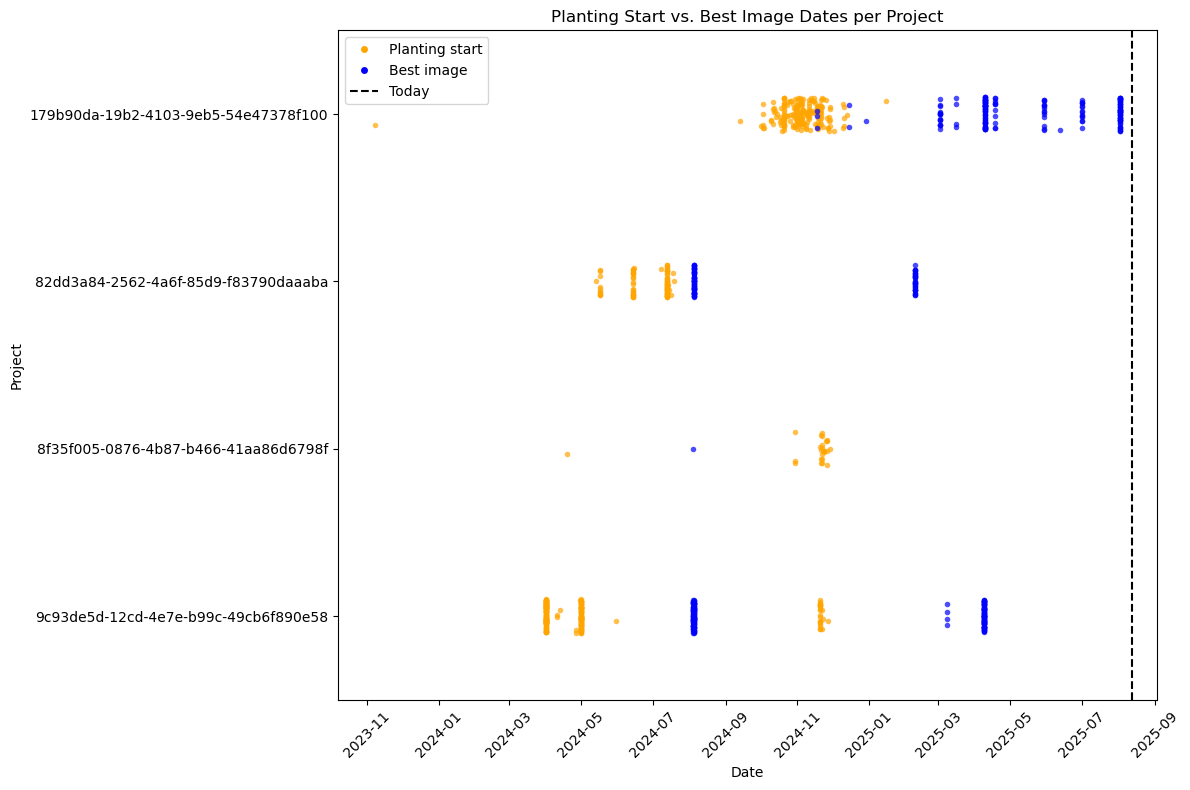

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.lines import Line2D

# Ensure datetime format
best_img_df['plantstart'] = pd.to_datetime(best_img_df['plantstart'])
best_img_df['img_date'] = pd.to_datetime(best_img_df['img_date'])

# Sort so projects appear nicely
best_img_df_sorted = best_img_df.sort_values(by=['project_id', 'plantstart'])

plt.figure(figsize=(12, 8))

# Plot planting start (orange)
sns.stripplot(
    data=best_img_df_sorted,
    x='plantstart',
    y='project_id',
    color='orange',
    alpha=0.7,
    size=4
)

# Plot best image (blue)
sns.stripplot(
    data=best_img_df_sorted,
    x='img_date',
    y='project_id',
    color='blue',
    alpha=0.7,
    size=4
)

# Add vertical line for today's date
today = pd.Timestamp(datetime.today().date())
plt.axvline(today, color='black', linestyle='--')

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=6, label='Planting start'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=6, label='Best image'),
    Line2D([0], [0], color='black', linestyle='--', label='Today')
]

# Move legend to top left
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Project")
plt.title("Planting Start vs. Best Image Dates per Project")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


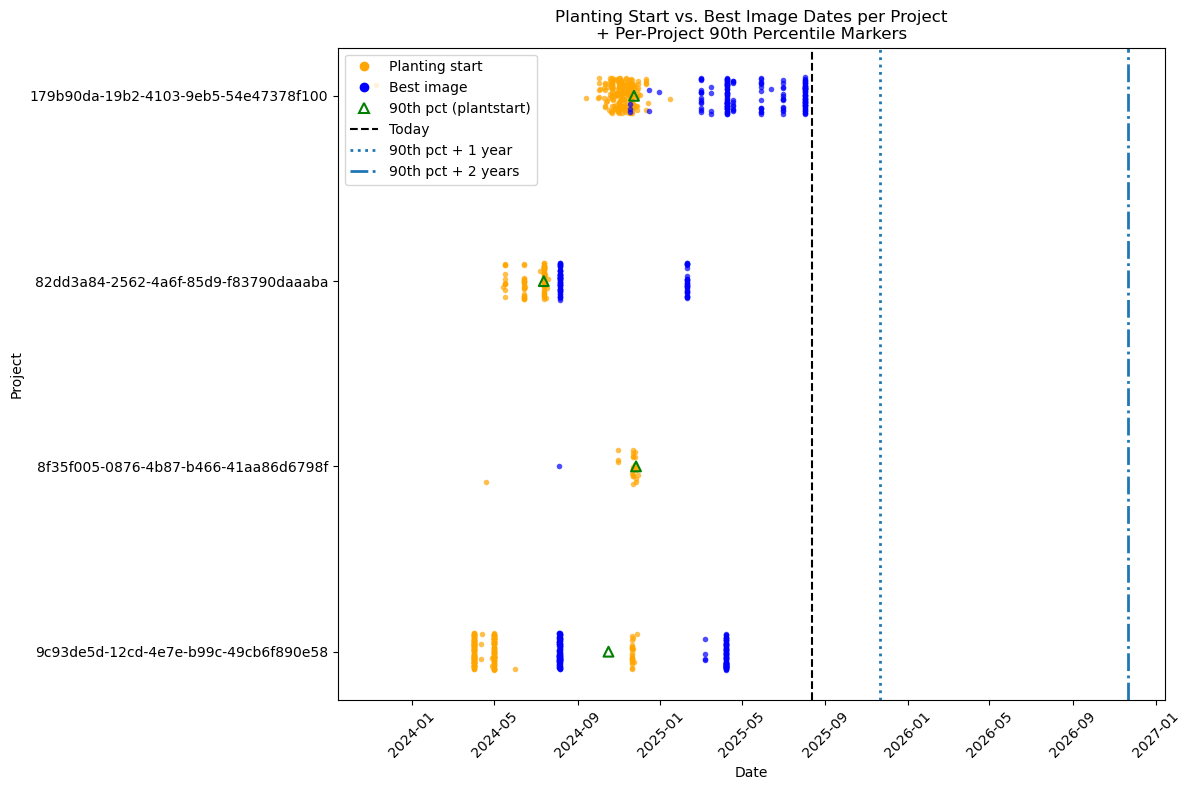

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.lines import Line2D

# --- Ensure datetime format ---
best_img_df['plantstart'] = pd.to_datetime(best_img_df['plantstart'])
best_img_df['img_date']   = pd.to_datetime(best_img_df['img_date'])

# --- Sort so projects appear nicely and lock in a stable y-order ---
best_img_df_sorted = best_img_df.sort_values(by=['project_id', 'plantstart'])
project_order = best_img_df_sorted['project_id'].dropna().unique().tolist()

plt.figure(figsize=(12, 8))

# --- Plantstart points (orange) ---
sns.stripplot(
    data=best_img_df_sorted,
    x='plantstart',
    y='project_id',
    order=project_order,
    color='orange',
    alpha=0.7,
    size=4
)

# --- Best image points (blue) ---
sns.stripplot(
    data=best_img_df_sorted,
    x='img_date',
    y='project_id',
    order=project_order,
    color='blue',
    alpha=0.7,
    size=4
)

ax = plt.gca()

# --- Vertical reference lines ---
today = pd.Timestamp(datetime.today().date())
ax.axvline(today, color='black', linestyle='--', linewidth=1.5)  # Today

# Global 90th percentile (across all projects)
plant_q90 = best_img_df_sorted['plantstart'].dropna().quantile(0.9)
q90_plus_1yr = plant_q90 + pd.DateOffset(years=1)
q90_plus_2yr = plant_q90 + pd.DateOffset(years=2)
ax.axvline(q90_plus_1yr, linestyle=':',  linewidth=2)  # 90th pct + 1 year
ax.axvline(q90_plus_2yr, linestyle='-.', linewidth=2)  # 90th pct + 2 years

# --- Per-project 90th percentile markers (one per project) ---
# Compute per-project Q90
proj_q90 = (
    best_img_df_sorted
    .dropna(subset=['plantstart'])
    .groupby('project_id')['plantstart']
    .quantile(0.9)
)

# Map project_id -> y-position used by seaborn (0-based)
# (Seaborn uses the category order we provided via `order=project_order`)
ypos_map = {pid: i for i, pid in enumerate(project_order)}

# Scatter one consistent marker per project at its Q90 date
# Using a triangle marker '^' with slight edge for visibility
for pid, qdate in proj_q90.items():
    if pd.notnull(qdate) and pid in ypos_map:
        ax.scatter(
            qdate, ypos_map[pid],
            marker='^',
            s=50,
            facecolor='none',    # hollow for clarity
            edgecolor='green',
            linewidth=1.5,
            zorder=3
        )

# --- Custom legend (single entry per thing) ---
legend_elements = [
    # Points
    Line2D([0], [0], marker='o', linestyle='None', color='orange',
           markerfacecolor='orange', markersize=6, label='Planting start'),
    Line2D([0], [0], marker='o', linestyle='None', color='blue',
           markerfacecolor='blue', markersize=6, label='Best image'),
    # Per-project Q90 marker
    Line2D([0], [0], marker='^', linestyle='None', color='green',
           markerfacecolor='none', markersize=7, markeredgewidth=1.5,
           label='90th pct (plantstart)'),
    # Vertical reference lines
    Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='Today'),
    Line2D([0], [0], linestyle=':',  linewidth=2, label='90th pct + 1 year'),
    Line2D([0], [0], linestyle='-.', linewidth=2, label='90th pct + 2 years'),
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

# --- Labels and formatting ---
plt.xlabel("Date")
plt.ylabel("Project")
plt.title("Planting Start vs. Best Image Dates per Project\n+ Per-Project 90th Percentile Markers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


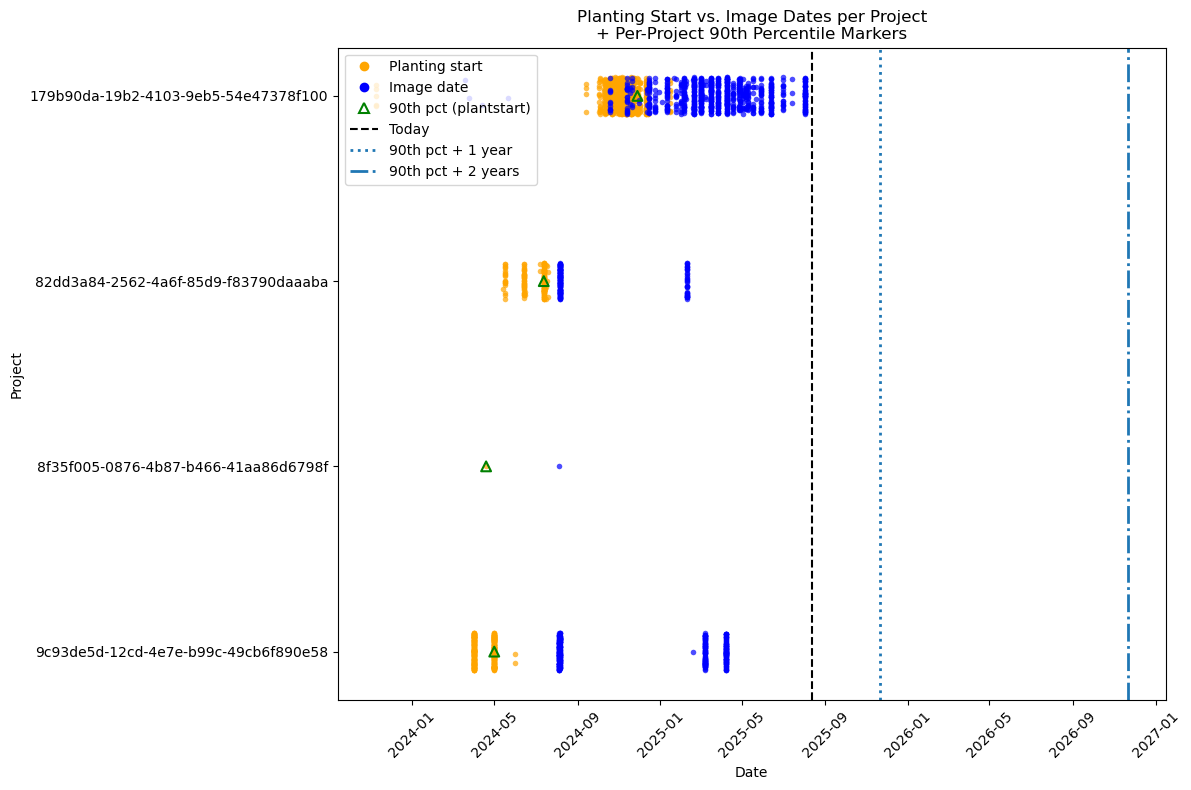

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.lines import Line2D

# --- Ensure datetime format ---
x['plantstart'] = pd.to_datetime(x['plantstart'])
x['img_date']   = pd.to_datetime(x['img_date'])

# --- Sort so projects appear nicely and lock in a stable y-order ---
x_sorted = x.sort_values(by=['project_id', 'plantstart'])
project_order = x_sorted['project_id'].dropna().unique().tolist()

plt.figure(figsize=(12, 8))

# --- Plantstart points (orange) ---
sns.stripplot(
    data=x_sorted,
    x='plantstart',
    y='project_id',
    order=project_order,
    color='orange',
    alpha=0.7,
    size=4
)

# --- Best image points (blue) ---
sns.stripplot(
    data=x_sorted,
    x='img_date',
    y='project_id',
    order=project_order,
    color='blue',
    alpha=0.7,
    size=4
)

ax = plt.gca()

# --- Vertical reference lines ---
today = pd.Timestamp(datetime.today().date())
ax.axvline(today, color='black', linestyle='--', linewidth=1.5)  # Today

# Global 90th percentile (across all projects)
plant_q90 = x_sorted['plantstart'].dropna().quantile(0.9)
q90_plus_1yr = plant_q90 + pd.DateOffset(years=1)
q90_plus_2yr = plant_q90 + pd.DateOffset(years=2)
ax.axvline(q90_plus_1yr, linestyle=':',  linewidth=2)  # 90th pct + 1 year
ax.axvline(q90_plus_2yr, linestyle='-.', linewidth=2)  # 90th pct + 2 years

# --- Per-project 90th percentile markers (one per project) ---
# Compute per-project Q90
proj_q90 = (
    x_sorted
    .dropna(subset=['plantstart'])
    .groupby('project_id')['plantstart']
    .quantile(0.9)
)

# Map project_id -> y-position used by seaborn (0-based)
# (Seaborn uses the category order we provided via `order=project_order`)
ypos_map = {pid: i for i, pid in enumerate(project_order)}

# Scatter one consistent marker per project at its Q90 date
# Using a triangle marker '^' with slight edge for visibility
for pid, qdate in proj_q90.items():
    if pd.notnull(qdate) and pid in ypos_map:
        ax.scatter(
            qdate, ypos_map[pid],
            marker='^',
            s=50,
            facecolor='none',    # hollow for clarity
            edgecolor='green',
            linewidth=1.5,
            zorder=3
        )

# --- Custom legend (single entry per thing) ---
legend_elements = [
    # Points
    Line2D([0], [0], marker='o', linestyle='None', color='orange',
           markerfacecolor='orange', markersize=6, label='Planting start'),
    Line2D([0], [0], marker='o', linestyle='None', color='blue',
           markerfacecolor='blue', markersize=6, label='Image date'),
    # Per-project Q90 marker
    Line2D([0], [0], marker='^', linestyle='None', color='green',
           markerfacecolor='none', markersize=7, markeredgewidth=1.5,
           label='90th pct (plantstart)'),
    # Vertical reference lines
    Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='Today'),
    Line2D([0], [0], linestyle=':',  linewidth=2, label='90th pct + 1 year'),
    Line2D([0], [0], linestyle='-.', linewidth=2, label='90th pct + 2 years'),
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

# --- Labels and formatting ---
plt.xlabel("Date")
plt.ylabel("Project")
plt.title("Planting Start vs. Image Dates per Project\n+ Per-Project 90th Percentile Markers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
